In [1]:
import os
import random
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

from tqdm.notebook import tqdm

from sklearn.metrics import classification_report, f1_score
from sklearn.model_selection import train_test_split

from IPython.display import clear_output
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()

In [2]:
df = pd.read_csv('/content/cybersequrity.csv')
df

,svcscan.fs_drivers,callbacks.ngeneric,psxview.not_in_eprocess_pool_false_avg,psxview.not_in_eprocess_pool,callbacks.nanonymous,psxview.not_in_session,psxview.not_in_pslist,psxview.not_in_pspcid_list,psxview.not_in_ethread_pool,psxview.not_in_csrss_handles,psxview.not_in_pslist_false_avg,psxview.not_in_pspcid_list_false_avg,psxview.not_in_deskthrd,psxview.not_in_ethread_pool_false_avg,psxview.not_in_session_false_avg,Class
0,26,8,0.0,0,0,2,0,0,0,4,0.000000,0.000000,6,0.000000,0.044444,1
1,26,8,0.0,0,0,5,3,3,3,7,0.073171,0.073171,9,0.073171,0.121951,1
2,26,8,0.0,0,0,9,7,7,7,11,0.152174,0.152174,13,0.152174,0.195652,1
3,26,8,0.0,0,0,3,1,1,2,6,0.022222,0.022222,9,0.044444,0.066667,1
4,26,8,0.0,0,0,2,0,0,0,4,0.000000,0.000000,6,0.000000,0.048780,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,26,8,0.0,0,0,4,2,2,2,6,0.048780,0.048780,8,0.048780,0.097561,1
9996,26,8,0.0,0,0,2,0,0,0,4,0.000000,0.000000,5,0.000000,0.062500,1
9997,26,8,0.0,0,1,2,0,0,0,4,0.000000,0.000000,5,0.000000,0.062500,1
9998,26,8,0.0,0,0,8,6,6,7,11,0.127629,0.127629,13,0.148511,0.169392,0


In [3]:
def set_seed(seed: int = 42) -> None:
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ["PYTHONHASHSEED"] = str(seed)
    print(f"Random seed set as {seed}")

set_seed(42)

Random seed set as 42


In [4]:
from sklearn.preprocessing import StandardScaler

In [5]:
X = df.drop(columns=["Class"])
y = df["Class"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

X_train.shape, X_val.shape, X_test.shape

((6000, 15), (2000, 15), (2000, 15))

In [6]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [7]:
class MalwareDataset(Dataset):
    def __init__(self, features, labels):
        self.features = torch.tensor(features, dtype=torch.float32)
        self.labels = torch.tensor(labels.values, dtype=torch.long)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

In [8]:
train_dataset = MalwareDataset(X_train_scaled, y_train)
val_dataset = MalwareDataset(X_val_scaled, y_val)
test_dataset = MalwareDataset(X_test_scaled, y_test)

In [13]:
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

**Модель с ReLu**

In [ ]:
class MLPModel(nn.Module):
    def __init__(self, input_size, hidden_sizes):
        super(MLPModel, self).__init__()
        layers = []
        current_size = input_size

        for hidden_size in hidden_sizes:
            layers.append(nn.Linear(current_size, hidden_size))
            layers.append(nn.ReLU())  # Выбор функции активации
            current_size = hidden_size

        layers.append(nn.Linear(current_size, 1))
        layers.append(nn.Sigmoid())  # Для бинарной классификации
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

# Определение параметров модели
input_size = X_train_scaled.shape[1]
hidden_sizes = [64, 32]  # Оптимальные размеры скрытых слоев

# Создание модели
model = MLPModel(input_size, hidden_sizes)

# Перевод модели на GPU, если доступно
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)


print(model)

MLPModel(
  (network): Sequential(
    (0): Linear(in_features=15, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=1, bias=True)
    (5): Sigmoid()
  )
)


Epoch 1/50, Train Loss: 0.6676, Val Loss: 0.6511
Epoch 2/50, Train Loss: 0.6380, Val Loss: 0.6292
Epoch 3/50, Train Loss: 0.6090, Val Loss: 0.6015
Epoch 4/50, Train Loss: 0.5799, Val Loss: 0.5801
Epoch 5/50, Train Loss: 0.5511, Val Loss: 0.5454
Epoch 6/50, Train Loss: 0.5314, Val Loss: 0.5315
Epoch 7/50, Train Loss: 0.5156, Val Loss: 0.5203
Epoch 8/50, Train Loss: 0.5051, Val Loss: 0.5151
Epoch 9/50, Train Loss: 0.4931, Val Loss: 0.5493
Epoch 10/50, Train Loss: 0.4884, Val Loss: 0.5075
Epoch 11/50, Train Loss: 0.4851, Val Loss: 0.4977
Epoch 12/50, Train Loss: 0.4770, Val Loss: 0.5029
Epoch 13/50, Train Loss: 0.4768, Val Loss: 0.4877
Epoch 14/50, Train Loss: 0.4734, Val Loss: 0.4982
Epoch 15/50, Train Loss: 0.4714, Val Loss: 0.5163
Epoch 16/50, Train Loss: 0.4727, Val Loss: 0.4837
Epoch 17/50, Train Loss: 0.4671, Val Loss: 0.4859
Epoch 18/50, Train Loss: 0.4650, Val Loss: 0.4941
Epoch 19/50, Train Loss: 0.4692, Val Loss: 0.4803
Epoch 20/50, Train Loss: 0.4647, Val Loss: 0.4764
Epoch 21/

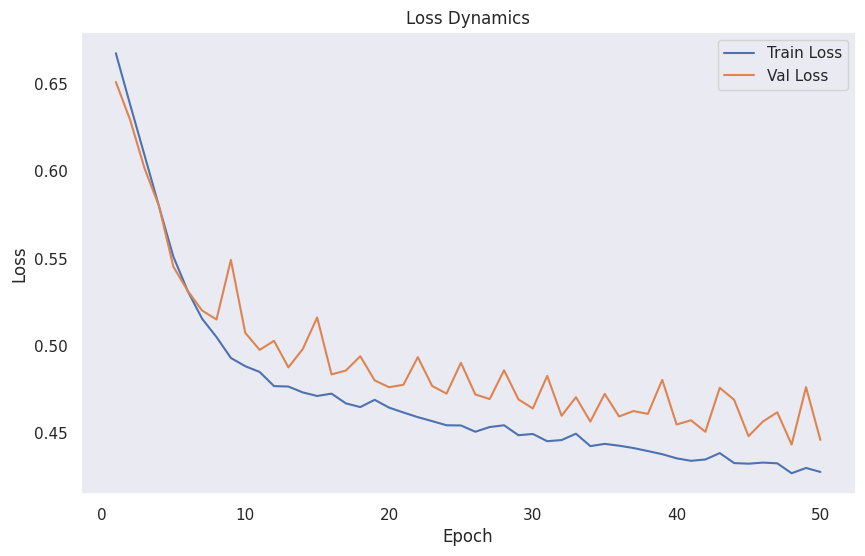

In [ ]:
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Циклы обучения и валидации
num_epochs = 50
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    # Train loop
    model.train()
    train_loss = 0.0
    for features, labels in train_loader:
        features, labels = features.to(device), labels.to(device)

        # Добавляем новое измерение к labels и преобразуем к Float
        labels = labels.unsqueeze(1).float()

        optimizer.zero_grad()
        outputs = model(features)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * features.size(0)

    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for features, labels in val_loader:
            features, labels = features.to(device), labels.to(device)
            outputs = model(features)
            labels = labels.unsqueeze(1).float()
            loss = criterion(outputs, labels)
            val_loss += loss.item() * features.size(0)

    val_loss /= len(val_loader.dataset)
    val_losses.append(val_loss)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

# Визуализация динамики функции потерь
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_losses, label="Train Loss")
plt.plot(range(1, num_epochs + 1), val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Dynamics")
plt.legend()
plt.grid()
plt.show()

In [ ]:
model.eval()
predictions = []
true_labels = []

with torch.no_grad():
    for features, labels in test_loader:
        features = features.to(device)
        outputs = model(features)
        predictions.extend(outputs.cpu().numpy())
        true_labels.extend(labels.numpy())

predictions = [1 if pred > 0.5 else 0 for pred in predictions]
print(classification_report(true_labels, predictions))

              precision    recall  f1-score   support

           0       0.78      0.88      0.83       988
           1       0.87      0.76      0.81      1012

    accuracy                           0.82      2000
   macro avg       0.83      0.82      0.82      2000
weighted avg       0.83      0.82      0.82      2000



**Модель с Sigmoid**

In [ ]:
class MLPModel(nn.Module):
    def __init__(self, input_size, hidden_sizes):
        super(MLPModel, self).__init__()
        layers = []
        current_size = input_size

        for hidden_size in hidden_sizes:
            layers.append(nn.Linear(current_size, hidden_size))
            layers.append(nn.Sigmoid())  # Выбор функции активации
            current_size = hidden_size

        layers.append(nn.Linear(current_size, 1))
        layers.append(nn.Sigmoid())  # Для бинарной классификации
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

# Определение параметров модели
input_size = X_train_scaled.shape[1]
hidden_sizes = [64, 32]  # Оптимальные размеры скрытых слоев

# Создание модели
model = MLPModel(input_size, hidden_sizes)

# Перевод модели на GPU, если доступно
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)


print(model)

MLPModel(
  (network): Sequential(
    (0): Linear(in_features=15, out_features=64, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): Sigmoid()
    (4): Linear(in_features=32, out_features=1, bias=True)
    (5): Sigmoid()
  )
)


Epoch 1/50, Train Loss: 0.6897, Val Loss: 0.6808
Epoch 2/50, Train Loss: 0.6808, Val Loss: 0.6731
Epoch 3/50, Train Loss: 0.6754, Val Loss: 0.6690
Epoch 4/50, Train Loss: 0.6710, Val Loss: 0.6665
Epoch 5/50, Train Loss: 0.6674, Val Loss: 0.6606
Epoch 6/50, Train Loss: 0.6598, Val Loss: 0.6588
Epoch 7/50, Train Loss: 0.6534, Val Loss: 0.6518
Epoch 8/50, Train Loss: 0.6466, Val Loss: 0.6431
Epoch 9/50, Train Loss: 0.6411, Val Loss: 0.6451
Epoch 10/50, Train Loss: 0.6362, Val Loss: 0.6344
Epoch 11/50, Train Loss: 0.6307, Val Loss: 0.6355
Epoch 12/50, Train Loss: 0.6263, Val Loss: 0.6253
Epoch 13/50, Train Loss: 0.6218, Val Loss: 0.6222
Epoch 14/50, Train Loss: 0.6159, Val Loss: 0.6176
Epoch 15/50, Train Loss: 0.6106, Val Loss: 0.6115
Epoch 16/50, Train Loss: 0.6043, Val Loss: 0.6059
Epoch 17/50, Train Loss: 0.5969, Val Loss: 0.6045
Epoch 18/50, Train Loss: 0.5907, Val Loss: 0.6112
Epoch 19/50, Train Loss: 0.5854, Val Loss: 0.5860
Epoch 20/50, Train Loss: 0.5782, Val Loss: 0.5794
Epoch 21/

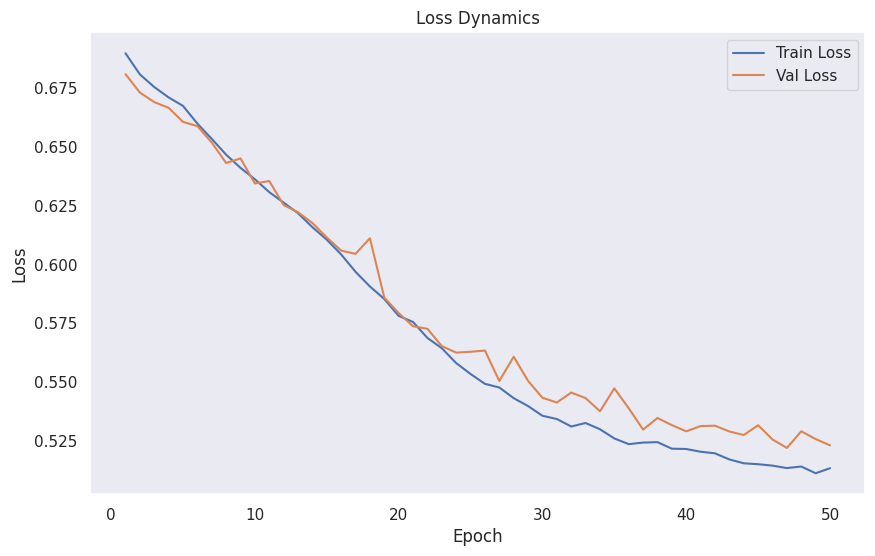

In [ ]:
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Циклы обучения и валидации
num_epochs = 50
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    # Train loop
    model.train()
    train_loss = 0.0
    for features, labels in train_loader:
        features, labels = features.to(device), labels.to(device)

        # Добавляем новое измерение к labels и преобразуем к Float
        labels = labels.unsqueeze(1).float()

        optimizer.zero_grad()
        outputs = model(features)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * features.size(0)

    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for features, labels in val_loader:
            features, labels = features.to(device), labels.to(device)
            outputs = model(features)
            labels = labels.unsqueeze(1).float()
            loss = criterion(outputs, labels)
            val_loss += loss.item() * features.size(0)

    val_loss /= len(val_loader.dataset)
    val_losses.append(val_loss)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

# Визуализация динамики функции потерь
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_losses, label="Train Loss")
plt.plot(range(1, num_epochs + 1), val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Dynamics")
plt.legend()
plt.grid()
plt.show()

In [ ]:
model.eval()
predictions = []
true_labels = []

with torch.no_grad():
    for features, labels in test_loader:
        features = features.to(device)
        outputs = model(features)
        predictions.extend(outputs.cpu().numpy())
        true_labels.extend(labels.numpy())

predictions = [1 if pred > 0.5 else 0 for pred in predictions]
print(classification_report(true_labels, predictions))

              precision    recall  f1-score   support

           0       0.78      0.68      0.73       988
           1       0.72      0.81      0.77      1012

    accuracy                           0.75      2000
   macro avg       0.75      0.75      0.75      2000
weighted avg       0.75      0.75      0.75      2000



Так как для бинарной классификации больше подходят Relu и Sigmoid, и по отчету метрик что при использовании Relu кочество модели выше. Будем оптимизировать модель с Relu

In [ ]:
class ImprovedMLPModel(nn.Module):
    def __init__(self, input_size, hidden_sizes, dropout_prob=0.3):
        super(ImprovedMLPModel, self).__init__()
        layers = []
        current_size = input_size

        for hidden_size in hidden_sizes:
            layers.append(nn.Linear(current_size, hidden_size))
            layers.append(nn.BatchNorm1d(hidden_size))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout_prob))
            current_size = hidden_size

        layers.append(nn.Linear(current_size, 1))
        layers.append(nn.Sigmoid())

        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

input_size = X_train_scaled.shape[1]
hidden_sizes = [64, 32]
dropout_prob = 0.3

model = ImprovedMLPModel(input_size, hidden_sizes, dropout_prob)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
print(model)

ImprovedMLPModel(
  (network): Sequential(
    (0): Linear(in_features=15, out_features=64, bias=True)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=64, out_features=32, bias=True)
    (5): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.3, inplace=False)
    (8): Linear(in_features=32, out_features=1, bias=True)
    (9): Sigmoid()
  )
)


In [ ]:
print(f"X_train_scaled: {X_train_scaled.dtype}")
print(f"labels: {labels.dtype}")

X_train_scaled: float64
labels: torch.int64


Epoch 1/50, Train Loss: 0.6439, Val Loss: 0.6478
Epoch 2/50, Train Loss: 0.6024, Val Loss: 0.6354
Epoch 3/50, Train Loss: 0.5711, Val Loss: 0.6358
Epoch 4/50, Train Loss: 0.5769, Val Loss: 0.5737
Epoch 5/50, Train Loss: 0.5614, Val Loss: 0.5783
Epoch 6/50, Train Loss: 0.5552, Val Loss: 0.5861
Epoch 7/50, Train Loss: 0.5500, Val Loss: 0.5576
Epoch 8/50, Train Loss: 0.5556, Val Loss: 0.6242
Epoch 9/50, Train Loss: 0.5411, Val Loss: 0.6147
Epoch 10/50, Train Loss: 0.5438, Val Loss: 0.5934
Epoch 11/50, Train Loss: 0.5336, Val Loss: 0.5983
Epoch 12/50, Train Loss: 0.5392, Val Loss: 0.5655
Epoch 13/50, Train Loss: 0.5377, Val Loss: 0.5105
Epoch 14/50, Train Loss: 0.5267, Val Loss: 0.5665
Epoch 15/50, Train Loss: 0.5335, Val Loss: 0.6073
Epoch 16/50, Train Loss: 0.5208, Val Loss: 0.5363
Epoch 17/50, Train Loss: 0.5308, Val Loss: 0.6008
Epoch 18/50, Train Loss: 0.5188, Val Loss: 0.5959
Epoch 19/50, Train Loss: 0.5262, Val Loss: 0.5553
Epoch 20/50, Train Loss: 0.5258, Val Loss: 0.5586
Epoch 21/

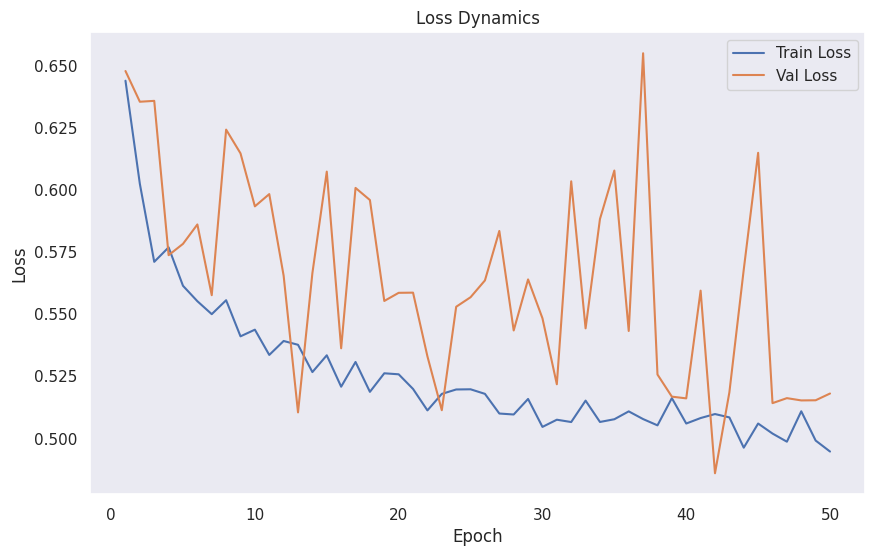

In [ ]:
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Циклы обучения и валидации
num_epochs = 50
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    # Train loop
    model.train()
    train_loss = 0.0
    for features, labels in train_loader:
        #features, labels = features.to(device), labels.to(device)

        labels = labels.unsqueeze(1).float()

        optimizer.zero_grad()
        outputs = model(features)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * features.size(0)

    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for features, labels in val_loader:
            features, labels = features.to(device), labels.to(device)
            outputs = model(features)
            labels = labels.unsqueeze(1).float()
            loss = criterion(outputs, labels)
            val_loss += loss.item() * features.size(0)

    val_loss /= len(val_loader.dataset)
    val_losses.append(val_loss)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

# Визуализация динамики функции потерь
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_losses, label="Train Loss")
plt.plot(range(1, num_epochs + 1), val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Dynamics")
plt.legend()
plt.grid()
plt.show()

In [ ]:
model.eval()
predictions = []
true_labels = []

with torch.no_grad():
    for features, labels in test_loader:
        features = features.to(device)
        outputs = model(features)
        predictions.extend(outputs.cpu().numpy())
        true_labels.extend(labels.numpy())

# Преобразование выходов в 0 или 1 для бинарной классификации
predictions = [1 if pred > 0.5 else 0 for pred in predictions]
print(classification_report(true_labels, predictions))

              precision    recall  f1-score   support

           0       0.80      0.67      0.73       988
           1       0.72      0.84      0.78      1012

    accuracy                           0.76      2000
   macro avg       0.76      0.75      0.75      2000
weighted avg       0.76      0.76      0.75      2000



Отчет по метрикам, если БачНорм после активации

In [ ]:
model.eval()
predictions = []
true_labels = []

with torch.no_grad():
    for features, labels in test_loader:
        features = features.to(device)
        outputs = model(features)
        predictions.extend(outputs.cpu().numpy())
        true_labels.extend(labels.numpy())

# Преобразование выходов в 0 или 1 для бинарной классификации
predictions = [1 if pred > 0.5 else 0 for pred in predictions]
print(classification_report(true_labels, predictions))

              precision    recall  f1-score   support

           0       0.66      0.96      0.78       988
           1       0.92      0.51      0.66      1012

    accuracy                           0.73      2000
   macro avg       0.79      0.73      0.72      2000
weighted avg       0.79      0.73      0.72      2000



In [22]:
class BestTorchModel_BN_Dropout_again(nn.Module):
    def __init__(self, num_labels, input_size, hidden_size, n_linear_layers=3, activation=nn.ReLU):
        super(BestTorchModel_BN_Dropout_again, self).__init__()

        layers = [nn.Linear(input_size, hidden_size), nn.BatchNorm1d(hidden_size), activation()]

        for i in range(n_linear_layers - 1):
            layers.append(nn.Linear(hidden_size, hidden_size))
            layers.append(nn.BatchNorm1d(hidden_size))
            if i == 0:
              layers.append(nn.Dropout(p=0.2))
            layers.append(activation())

        layers.append(nn.Linear(hidden_size, num_labels))
        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        y_pred = torch.sigmoid(self.layers(x))
        return y_pred

In [29]:
model = BestTorchModel_BN_Dropout_again(1, 15, 35, 3)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

loss_function = nn.BCELoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0005)

model

BestTorchModel_BN_Dropout_again(
  (layers): Sequential(
    (0): Linear(in_features=15, out_features=35, bias=True)
    (1): BatchNorm1d(35, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=35, out_features=35, bias=True)
    (4): BatchNorm1d(35, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): Dropout(p=0.2, inplace=False)
    (6): ReLU()
    (7): Linear(in_features=35, out_features=35, bias=True)
    (8): BatchNorm1d(35, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU()
    (10): Linear(in_features=35, out_features=1, bias=True)
  )
)

Epoch 1/75, Train Loss: 0.6383, Val Loss: 0.6517
Epoch 2/75, Train Loss: 0.5751, Val Loss: 0.6332
Epoch 3/75, Train Loss: 0.5433, Val Loss: 0.6394
Epoch 4/75, Train Loss: 0.5278, Val Loss: 0.6302
Epoch 5/75, Train Loss: 0.5110, Val Loss: 0.5690
Epoch 6/75, Train Loss: 0.5158, Val Loss: 0.6310
Epoch 7/75, Train Loss: 0.5018, Val Loss: 0.6272
Epoch 8/75, Train Loss: 0.5015, Val Loss: 0.5846
Epoch 9/75, Train Loss: 0.4996, Val Loss: 0.5438
Epoch 10/75, Train Loss: 0.4862, Val Loss: 0.5743
Epoch 11/75, Train Loss: 0.4852, Val Loss: 0.5377
Epoch 12/75, Train Loss: 0.4821, Val Loss: 0.5319
Epoch 13/75, Train Loss: 0.4829, Val Loss: 0.5328
Epoch 14/75, Train Loss: 0.4708, Val Loss: 0.5659
Epoch 15/75, Train Loss: 0.4737, Val Loss: 0.6080
Epoch 16/75, Train Loss: 0.4659, Val Loss: 0.6017
Epoch 17/75, Train Loss: 0.4684, Val Loss: 0.5673
Epoch 18/75, Train Loss: 0.4733, Val Loss: 0.6178
Epoch 19/75, Train Loss: 0.4614, Val Loss: 0.5926
Epoch 20/75, Train Loss: 0.4628, Val Loss: 0.5889
Epoch 21/

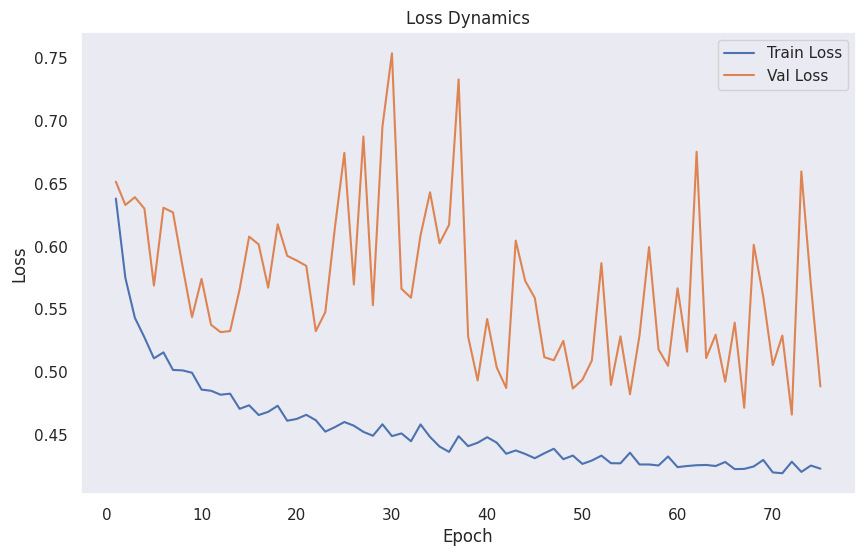

In [30]:
num_epochs = 75
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    # Train loop
    model.train()
    train_loss = 0.0
    for features, labels in train_loader:
        #features, labels = features.to(device), labels.to(device)

        labels = labels.unsqueeze(1).float()

        optimizer.zero_grad()
        outputs = model(features)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * features.size(0)

    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for features, labels in val_loader:
            features, labels = features.to(device), labels.to(device)
            outputs = model(features)
            labels = labels.unsqueeze(1).float()
            loss = loss_function(outputs, labels)
            val_loss += loss.item() * features.size(0)

    val_loss /= len(val_loader.dataset)
    val_losses.append(val_loss)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

# Визуализация динамики функции потерь
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_losses, label="Train Loss")
plt.plot(range(1, num_epochs + 1), val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Dynamics")
plt.legend()
plt.grid()
plt.show()

In [31]:
model.eval()
predictions = []
true_labels = []

with torch.no_grad():
    for features, labels in test_loader:
        features = features.to(device)
        outputs = model(features)
        predictions.extend(outputs.cpu().numpy())
        true_labels.extend(labels.numpy())

# Преобразование выходов в 0 или 1 для бинарной классификации
predictions = [1 if pred > 0.5 else 0 for pred in predictions]
print(classification_report(true_labels, predictions))

              precision    recall  f1-score   support

           0       0.82      0.82      0.82       988
           1       0.82      0.83      0.83      1012

    accuracy                           0.82      2000
   macro avg       0.82      0.82      0.82      2000
weighted avg       0.82      0.82      0.82      2000



In [ ]:
model.eval()
predictions = []
true_labels = []

with torch.no_grad():
    for features, labels in test_loader:
        features = features.to(device)
        outputs = model(features)
        predictions.extend(outputs.cpu().numpy())
        true_labels.extend(labels.numpy())

# Преобразование выходов в 0 или 1 для бинарной классификации
predictions = [1 if pred > 0.5 else 0 for pred in predictions]
print(classification_report(true_labels, predictions))

              precision    recall  f1-score   support

           0       0.77      0.90      0.83       988
           1       0.89      0.74      0.81      1012

    accuracy                           0.82      2000
   macro avg       0.83      0.82      0.82      2000
weighted avg       0.83      0.82      0.82      2000



l=0.0005, p =0.2

In [ ]:
model.eval()
predictions = []
true_labels = []

with torch.no_grad():
    for features, labels in test_loader:
        features = features.to(device)
        outputs = model(features)
        predictions.extend(outputs.cpu().numpy())
        true_labels.extend(labels.numpy())

# Преобразование выходов в 0 или 1 для бинарной классификации
predictions = [1 if pred > 0.5 else 0 for pred in predictions]
print(classification_report(true_labels, predictions))

              precision    recall  f1-score   support

           0       0.79      0.85      0.82       988
           1       0.84      0.78      0.81      1012

    accuracy                           0.82      2000
   macro avg       0.82      0.82      0.82      2000
weighted avg       0.82      0.82      0.82      2000



парметры l=0.0005, p=0.4

In [ ]:
model.eval()
predictions = []
true_labels = []

with torch.no_grad():
    for features, labels in test_loader:
        features = features.to(device)
        outputs = model(features)
        predictions.extend(outputs.cpu().numpy())
        true_labels.extend(labels.numpy())

# Преобразование выходов в 0 или 1 для бинарной классификации
predictions = [1 if pred > 0.5 else 0 for pred in predictions]
print(classification_report(true_labels, predictions))

              precision    recall  f1-score   support

           0       0.78      0.83      0.80       988
           1       0.82      0.77      0.80      1012

    accuracy                           0.80      2000
   macro avg       0.80      0.80      0.80      2000
weighted avg       0.80      0.80      0.80      2000



p и l определялось экспериментным путем. Усложнением архитектуры удалось добиться метрики f1-score максимум 0.83